## predict the magnetic interaction between two atoms in a molecule (i.e., the scalar coupling constant)

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import GroupKFold,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn import metrics

print(os.listdir("../input"))

['potential_energy.csv', 'mulliken_charges.csv', 'train.csv', 'scalar_coupling_contributions.csv', 'sample_submission.csv', 'structures', 'test.csv', 'magnetic_shielding_tensors.csv', 'dipole_moments.csv', 'structures.csv']


In [18]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

## Train / Test Set

the training set, where the first column (molecule_name) is the name of the molecule where the coupling constant originates (the corresponding XYZ file is located at ./structures/.xyz), the second (atom_index_0) and third column (atom_index_1) is the atom indices of the atom-pair creating the coupling and the fourth column (scalar_coupling_constant) is the scalar coupling constant that we want to be able to predict

In [19]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [20]:
print ("Total Train Set : %d" %len(train))
print ('Total Test Set : %d' %len(test))

Total Train Set : 4658147
Total Test Set : 2505542


### Target : scalar_coupling_constant


In [21]:
train['scalar_coupling_constant'].describe()

count    4.658147e+06
mean     1.592165e+01
std      3.494198e+01
min     -3.621860e+01
25%     -2.549780e-01
50%      2.281130e+00
75%      7.390655e+00
max      2.048800e+02
Name: scalar_coupling_constant, dtype: float64

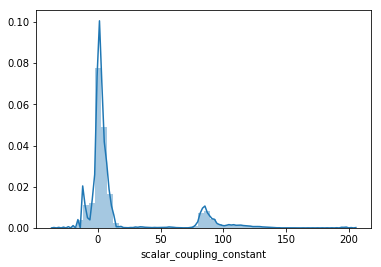

In [22]:
sns.distplot(train['scalar_coupling_constant'])

### Plot type / target correlation
Looks each type have some correlate to target

In [23]:
typelist = list(train['type'].value_counts().index)
typelist

['3JHC', '2JHC', '1JHC', '3JHH', '2JHH', '3JHN', '2JHN', '1JHN']

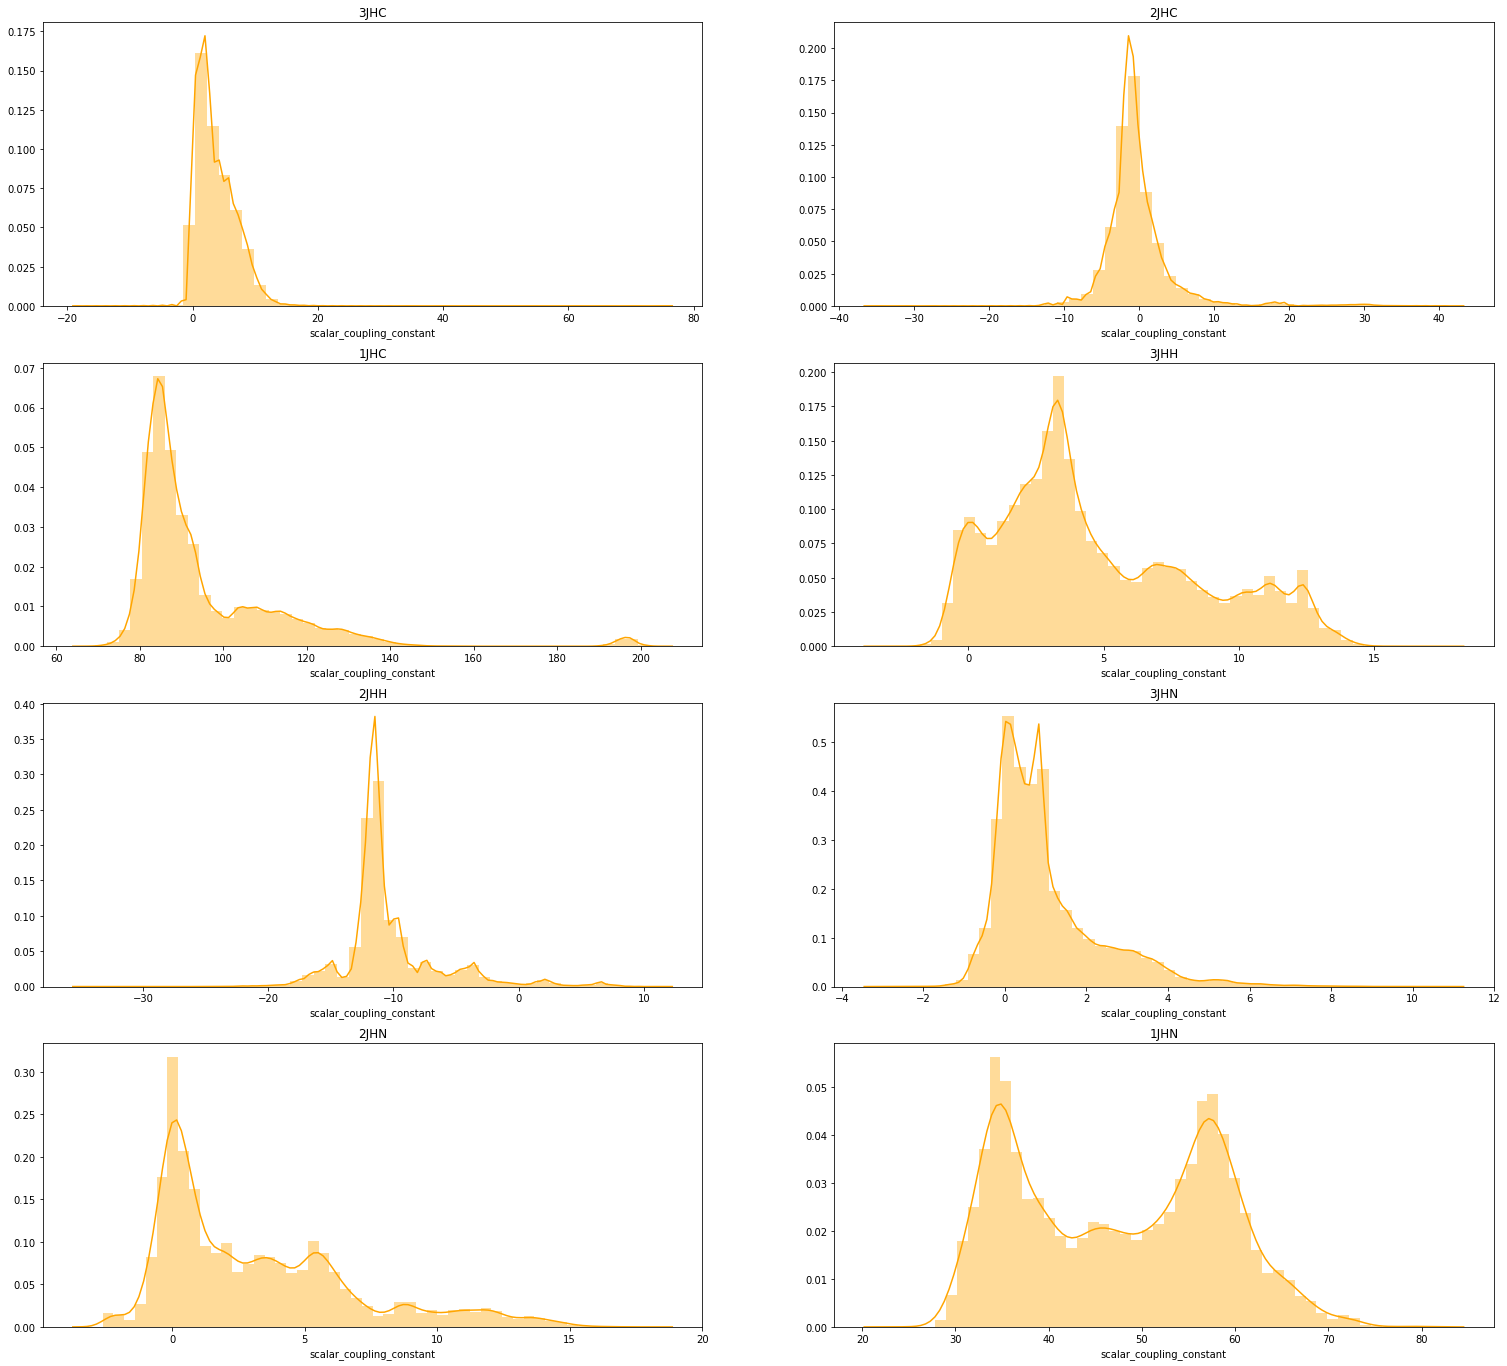

In [24]:
plt.figure(figsize=(26, 24))
for i, col in enumerate(typelist):
    plt.subplot(4,2, i + 1)
    sns.distplot(train[train['type']==col]['scalar_coupling_constant'],color ='orange')
    plt.title(col)

## Structure X/Y/Z

In [25]:
structures = pd.read_csv('../input/structures.csv')

In [26]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


## Merge the train set and structure set

In [27]:
#https://www.kaggle.com/inversion/atomic-distance-benchmark/output
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [28]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001


## FE - Distance of atom
the average distance between coupling atoms is likely to increase as a result of a longer coupling pathway, ergo more intervening bonds(1J, 2J, 3J)

In [29]:
#https://www.kaggle.com/inversion/atomic-distance-benchmark/output

train['dist'] = ((train['x_1'] - train['x_0'])**2 +
             (train['y_1'] - train['y_0'])**2 +
             (train['z_1'] - train['z_0'])**2 ) ** 0.5

test['dist'] = ((test['x_1'] - test['x_0'])**2 +
             (test['y_1'] - test['y_0'])**2 +
             (test['z_1'] - test['z_0'])**2 ) ** 0.5

## Label Encoding

In [30]:
molecules = train.pop('molecule_name')
test = test.drop('molecule_name', axis=1)
id_train = train.pop('id')
id_test = test.pop('id')

y = train.pop('scalar_coupling_constant')

# Label Encoding
for f in ['type', 'atom_0', 'atom_1']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [31]:
train.head()

,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist
0,1,0,0,0,0.002150,-0.006031,0.001976,0,-0.012698,1.085804,0.008001,1.091953
1,1,2,3,0,0.002150,-0.006031,0.001976,1,1.011731,1.463751,0.000277,1.783120
2,1,3,3,0,0.002150,-0.006031,0.001976,1,-0.540815,1.447527,-0.876644,1.783147
3,1,4,3,0,0.002150,-0.006031,0.001976,1,-0.523814,1.437933,0.906397,1.783157
4,2,0,0,0,1.011731,1.463751,0.000277,0,-0.012698,1.085804,0.008001,1.091952


## Training

In [32]:
## Evaluate matric
## https://www.kaggle.com/abhishek/competition-metric
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type":train["type"]})
eval_df["scalar_coupling_constant"] = y

In [33]:
n_splits = 5 # Number of K-fold Splits

splits = list(GroupKFold(n_splits=n_splits).split(train, y, groups=molecules))
splits[:3]

[(array([      0,       1,       2, ..., 4658066, 4658067, 4658068]),
  array([    149,     150,     151, ..., 4658144, 4658145, 4658146])),
 (array([      0,       1,       2, ..., 4658144, 4658145, 4658146]),
  array([     10,      11,      12, ..., 4656875, 4656876, 4656877])),
 (array([     10,      11,      12, ..., 4658144, 4658145, 4658146]),
  array([      0,       1,       2, ..., 4656757, 4656758, 4656759]))]

In [34]:
params = {"learning_rate" : 0.1,
          "depth": 9,
          'metric':'MAE',
          'min_samples_leaf': 3,
          "loss_function": "MAE"}

In [ ]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()
features = [c for c in train.columns if c not in ['id']]

for i, (train_idx, valid_idx) in enumerate(splits):  
    print(f'Fold {i + 1}')
    x_train = np.array(train)
    y_train = np.array(y)
    trn_data = lgb.Dataset(x_train[train_idx.astype(int)], label=y_train[train_idx.astype(int)])
    val_data = lgb.Dataset(x_train[valid_idx.astype(int)], label=y_train[valid_idx.astype(int)])
    
    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
    oof[valid_idx] = clf.predict(x_train[valid_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions[fake_data.index] += clf.predict(fake_data, num_iteration=clf.best_iteration) / n_splits
    predictions += clf.predict(test, num_iteration=clf.best_iteration) / n_splits

#print("CV score: {:<8.5f}".format(np.log(metrics.mean_absolute_error(train, oof))))

Fold 1
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 2.2829	valid_1's l1: 2.3008
[1000]	training's l1: 2.19183	valid_1's l1: 2.21908
[1500]	training's l1: 2.13518	valid_1's l1: 2.17071
[2000]	training's l1: 2.0942	valid_1's l1: 2.13748
[2500]	training's l1: 2.06062	valid_1's l1: 2.11128
[3000]	training's l1: 2.0313	valid_1's l1: 2.08846
[3500]	training's l1: 2.00568	valid_1's l1: 2.06955
[4000]	training's l1: 1.98332	valid_1's l1: 2.05364
[4500]	training's l1: 1.96402	valid_1's l1: 2.04065
[5000]	training's l1: 1.94519	valid_1's l1: 2.02819
[5500]	training's l1: 1.92746	valid_1's l1: 2.01614
[6000]	training's l1: 1.91191	valid_1's l1: 2.00633
[6500]	training's l1: 1.89718	valid_1's l1: 1.99743
[7000]	training's l1: 1.88313	valid_1's l1: 1.98891
[7500]	training's l1: 1.86899	valid_1's l1: 1.98028
[8000]	training's l1: 1.85605	valid_1's l1: 1.97271
[8500]	training's l1: 1.84427	valid_1's l1: 1.9661
[9000]	training's l1: 1.83241	valid_1's l1: 1.95921


In [ ]:
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

## Future work
* would totally like to apply xgboost,bagging and neural network
* likely to add more features based on additional data
*